In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pandas import DataFrame, Series

In [4]:
power = zipfile.ZipFile("/content/drive/My Drive/household_power_consumption.zip", "r")
power.extractall("power_consum")

In [5]:
df = pd.read_csv("/content/power_consum/household_power_consumption.txt", delimiter =";", na_values = "?", header = 0, 
                           low_memory = False, dtype = float, infer_datetime_format = True, 
                           parse_dates= {"datetime":[0,1]}, index_col= ["datetime"])

In [6]:
df_daily = df.fillna(df.mean()).resample('D').sum()
print(df_daily.isnull().sum())
df_daily.head()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [7]:
df_daily.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.041098,0.062472,0.999182,0.545338,0.481370,0.732613
Global_reactive_power,0.041098,1.000000,0.050499,0.062937,0.319394,0.182199,0.035568
Voltage,0.062472,0.050499,1.000000,0.052267,-0.003968,-0.013712,0.095774
Global_intensity,0.999182,0.062937,0.052267,1.000000,0.557974,0.490772,0.724146
Sub_metering_1,0.545338,0.319394,-0.003968,0.557974,1.000000,0.251585,0.308917
Sub_metering_2,0.481370,0.182199,-0.013712,0.490772,0.251585,1.000000,0.198360
Sub_metering_3,0.732613,0.035568,0.095774,0.724146,0.308917,0.198360,1.000000


Question 11

Text(0.5, 1.0, 'Daily global_active_power over time')

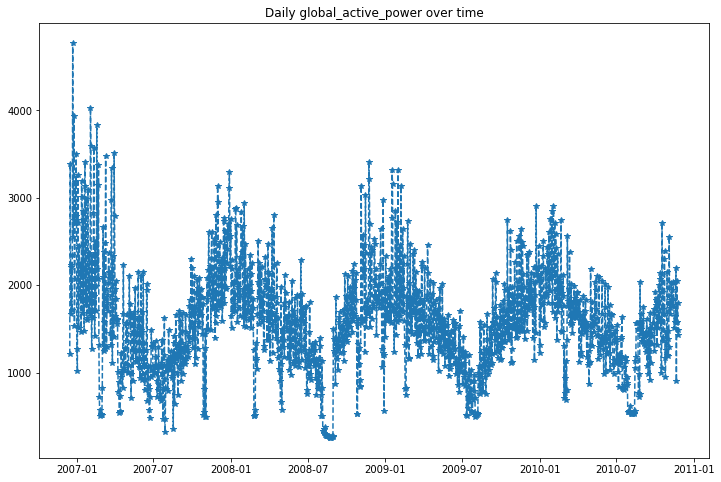

In [8]:
# A plot of the daily global_active_power over time

plt.figure(figsize=(12,8))
plt.plot(df_daily.index, df_daily['Global_active_power'], "--", marker = "*")
plt.title("Daily global_active_power over time")

Question 12: What is the Pearson correlation coefficient between the Global_active_power and the Global_reactive_power? To 2 decimal places.

In [9]:
# Pearson correlation coefficient between the Global_active_power and the Global_reactive_power
from scipy.stats import pearsonr
corr, _ = pearsonr(df_daily["Global_reactive_power"], df_daily["Global_active_power"])
round(corr,2)
print('Pearsons correlation: %.3f' % corr)


Pearsons correlation: 0.041


Question 13: What is the Pearson correlation coefficient between the Voltage and the Global_intensity? To 2 decimal places.

In [10]:
# Pearson correlation coefficient between the Voltage and the Global_intensity
from scipy.stats import pearsonr
corr, _ = pearsonr(df_daily["Voltage"], df_daily["Global_intensity"])
round(corr,2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.052


In [11]:
df_daily.shape

(1442, 7)

In [12]:
from fbprophet import Prophet

In [13]:
df_daily.reset_index(inplace = True)

In [14]:
df_daily.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [15]:
prophet_daily = df_daily[["datetime","Global_active_power"]].rename(columns = {'datetime':'ds','Global_active_power':'y',})

In [16]:
prophet_daily.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [17]:
#taking the first 1077 observations for training and last 365days for testing
train = prophet_daily.iloc[0:1077,:]
test = prophet_daily.iloc[1077:,:]
print(test.shape)
print(train.shape)

(365, 2)
(1077, 2)


In [18]:
#creating the model
model = Prophet()

In [19]:
#fitting the model to train data
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
#making prediction with test set
prediction = model.predict(test)

Question 14:

In [21]:
#calculating mape for the Univariant series
mape = sum(np.abs(np.array(test['y']) - np.array(prediction['yhat']))/np.array(test['y']))/ len(test) *100
round(mape,2)

20.88

Question 15:

In [22]:
#calculating rmse for the multivariant series
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test['y']),np.array(prediction['yhat'])))
round(rmse,2)

374.95

Question 16:What month of the yearly seasonality has the lowest value?

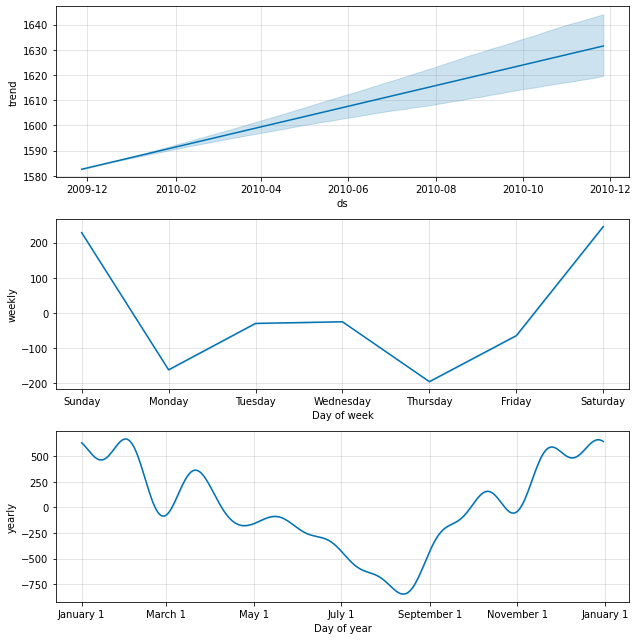

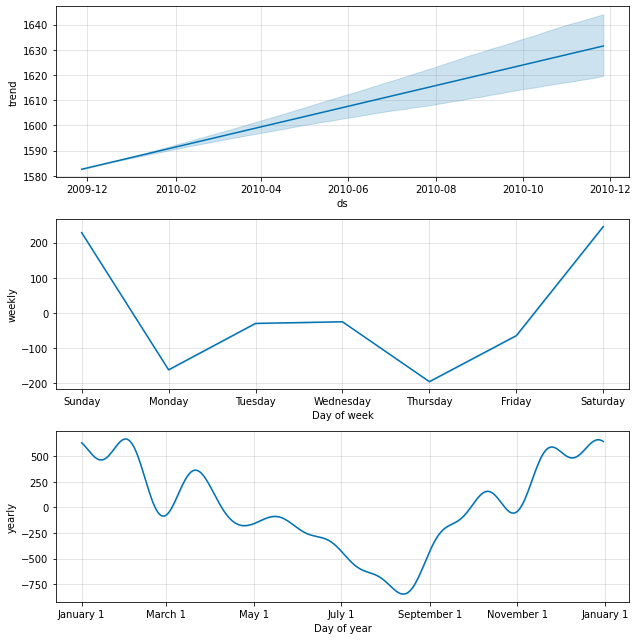

In [23]:
# visualize each components (trends, monthly and weekly)
model.plot_components(prediction)

Modeling Multivariant time series

In [24]:
prophet_daily1 = df_daily.rename(columns = {'datetime':'ds','Global_active_power':'y',
                                           'Global_reactive_power':'add1','Voltage':'add2',
                                           'Global_intensity':'add3','Sub_metering_1':'add4',
                                          'Sub_metering_2':'add5','Sub_metering_3':'add6'})

In [25]:
#taking the first 1077 observations for training and last 365days for testing
train1 = prophet_daily1.iloc[0:1077,:]
test1 = prophet_daily1.iloc[1077:,:]
print(test1.shape)
print(train1.shape)

(365, 8)
(1077, 8)


In [26]:
#creating the model
model1 = Prophet()
model1.add_regressor('add1')
model1.add_regressor('add2')
model1.add_regressor('add3')
model1.add_regressor('add4')
model1.add_regressor('add5')
model1.add_regressor('add6')

In [27]:
model1.fit(train1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
#making prediction with test set
prediction1 = model1.predict(test1)

Question 17: calculating the MAPE

In [29]:
#calculating mape
mape = np.mean(np.abs(np.array(test1['y']) -np.array(prediction1['yhat']))/ np.array(test1['y'])) *100
round(mape,2)                                                                      

2.63

Question 18: calculating RMSE

In [30]:
#calculating rmse
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test1['y']),np.array(prediction1['yhat'])))
round(rmse,2)

39.13

Question 19: What day of the daily seasonality has the lowest value

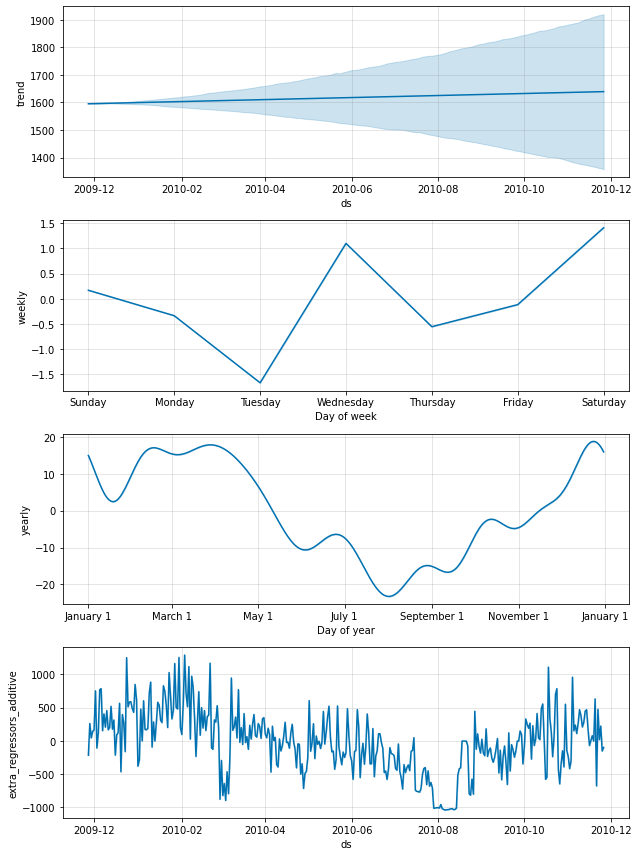

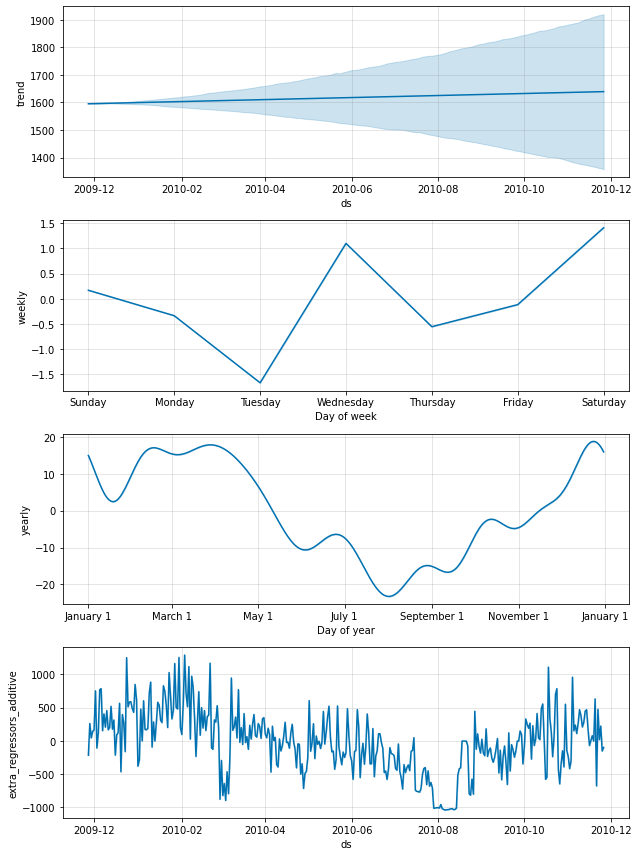

In [31]:
# visualize each components (trends, monthly)
model1.plot_components(prediction1)